# Box Covariance Outlier Detection

Z. W. Miller - Copyright 2018

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [3]:
import numpy as np
import pandas as pd

class box_covariance:
    
    def __init__(self, threshold=1.): 
        """
        Builds a box envelope around the data using a
        standard deviation threshold. Any points within this
        box are considered inliers, and points outside of this
        box are considered outliers. This is a fairly simplistic
        method that is not very robust to highly correlated
        data with "close by" outliers.
        ---
        KWargs:
        threhsold: how many standard deviations do you want
        to consider an "inlier"
        """
        self.threshold = threshold
        self.data_stats = {}
        self.number_of_columns = None
        
    def fit(self, X):
        """
        Learns about the input data and stores the mean and 
        standard deviation of each column.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        X = self.convert_to_array(X)
        self.number_of_columns = X.shape[1]
        
        for ix in range(self.number_of_columns):
            col = X.T[ix]
            col_mean = np.mean(col)
            col_std = np.std(col)
            self.data_stats[ix] = (col_mean, col_std)
            
    def predict(self, X):
        """
        For each data point, subtract the mean of the column
        and then see if the data point is within 
        threshold*std_dev of that column of 0. If so, it's an
        inlier. Otherwise it's an outlier.
        """
        X = self.convert_to_array(X)
        result = np.ones(X.shape[0])
        for ix in range(self.number_of_columns):
            X.T[ix] = X.T[ix] - self.data_stats[ix][0]
            result[(result != -1) & (np.abs(X.T[ix]) >= self.data_stats[ix][1]*self.threshold)] = -1
        return result
    
    def fit_predict(self, X):
        """
        Learn from X and then return the transformed version
        of X for the user to use.
        ---
        In: X (features); np.array or pandas dataframe/series
        """
        self.fit(X)
        return self.predict(X)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

In [4]:
train_data = [[0.5,0.5],[0.6,0.3],[0.5,0.4]]
bc = box_covariance()
bc.fit(train_data)

In [5]:
bc.data_stats

{0: (0.53333333333333333, 0.047140452079103161),
 1: (0.40000000000000008, 0.081649658092772609)}

In [6]:
bc.predict([[0.587142,0.48],[0.5,0.4]])

array([-1.,  1.])

## Now let's try with some more interesting data

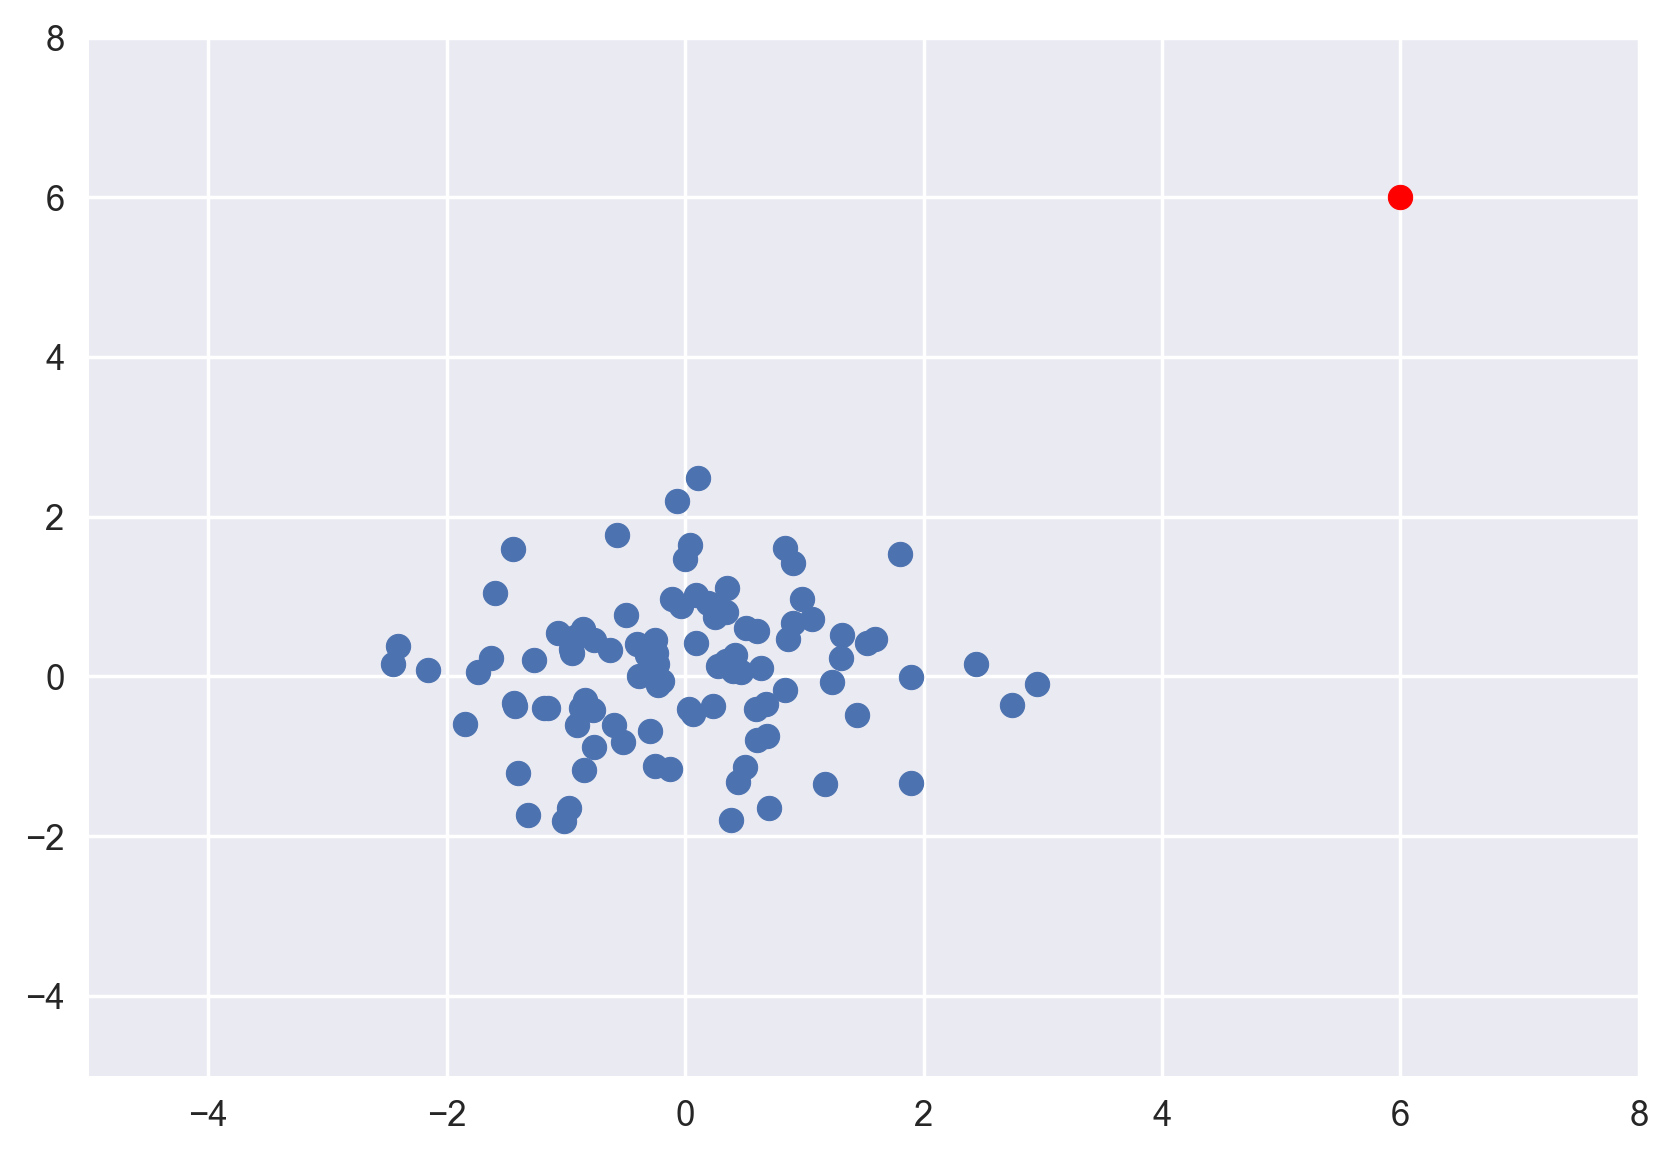

In [7]:
X = np.random.normal(0,1,size=(100,2))
outlier = np.array([6,6]).reshape(-1,2)
plt.figure(dpi=250)
plt.scatter(X[:,0], X[:,1])
plt.scatter(outlier[:,0], outlier[:,1],c='r')
plt.xlim(-5,8)
plt.ylim(-5,8);

In [8]:
bc = box_covariance(threshold=3)
bc.fit(X)

In [9]:
bc.predict(X)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [10]:
bc.predict(outlier)

array([-1.])

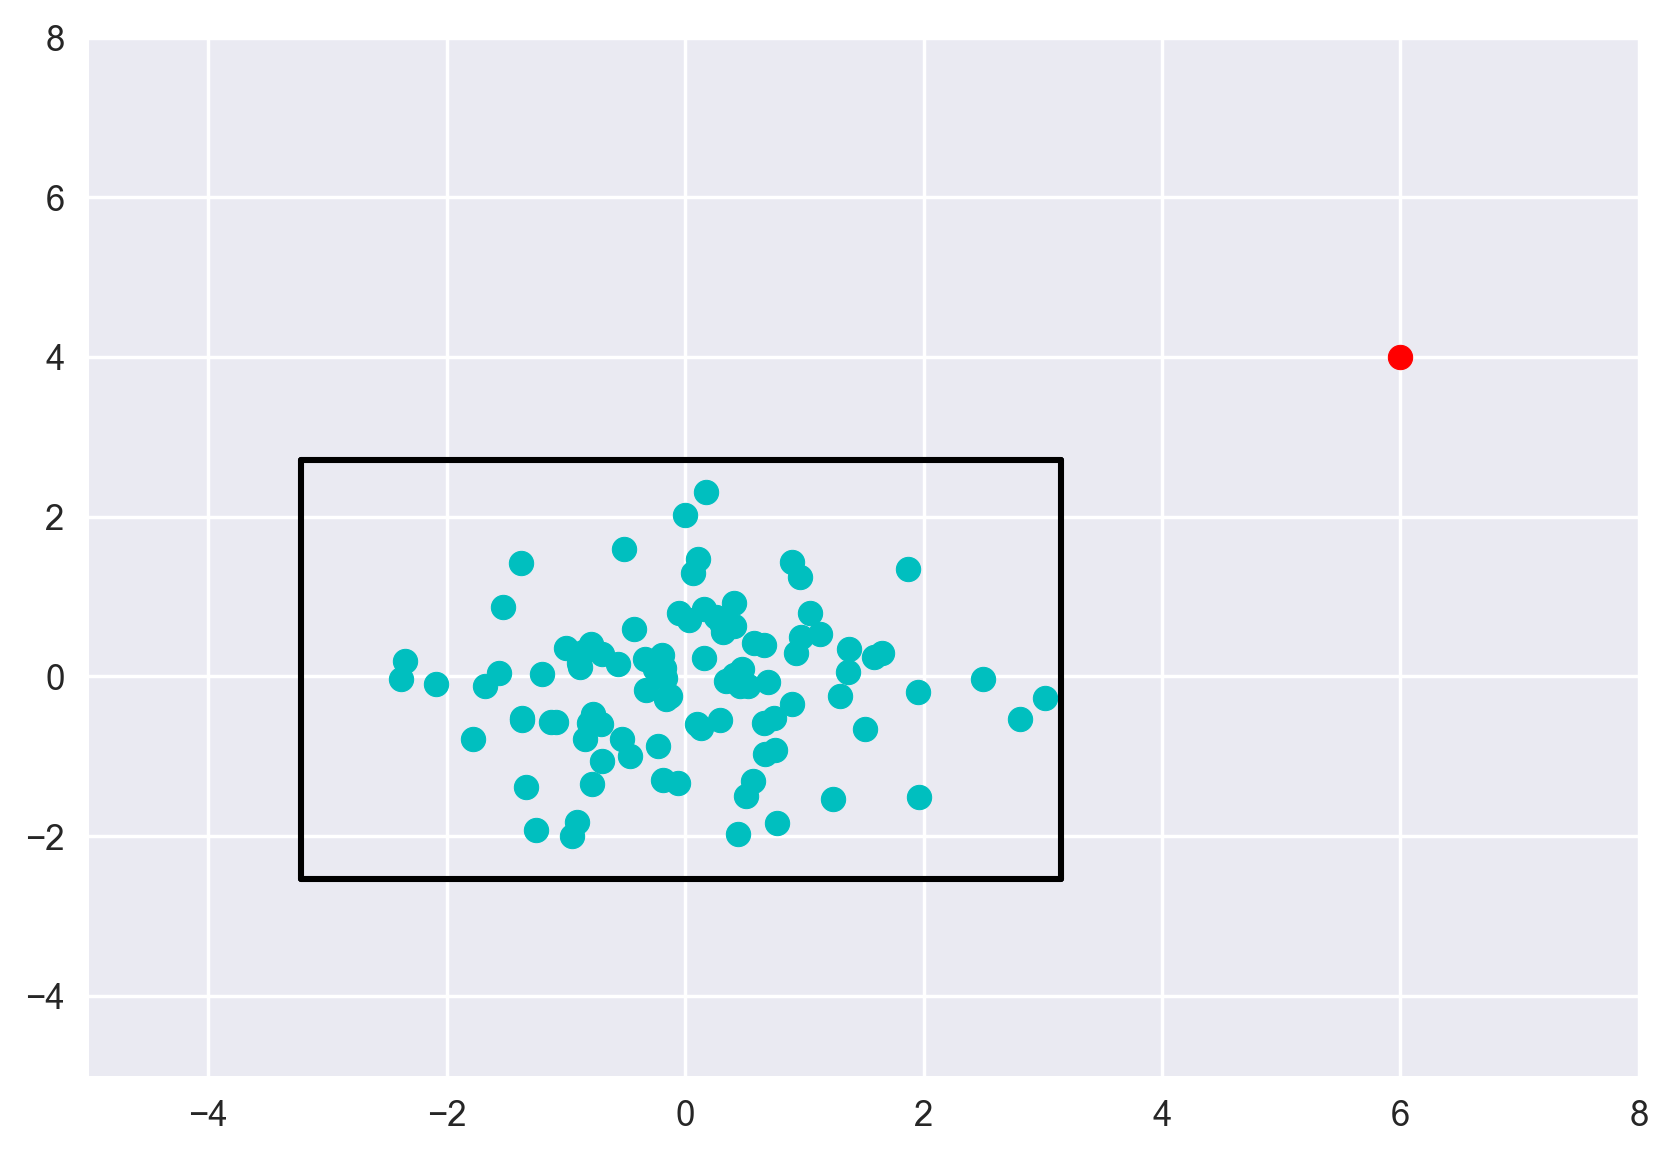

In [11]:
plt.figure(dpi=250)
for pt,label in zip(X,bc.predict(X)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c')
    else:
        plt.scatter(pt[0], pt[1],c='r') 
        
for pt,label in zip(outlier,bc.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c')
    else:
        plt.scatter(pt[0], pt[1],c='r')  
        
plt.xlim(-5,8)
plt.ylim(-5,8)
xlow = bc.data_stats[0][0] - bc.data_stats[0][1]*bc.threshold
xhigh = bc.data_stats[0][0] + bc.data_stats[0][1]*bc.threshold
ylow = bc.data_stats[1][0] - bc.data_stats[1][1]*bc.threshold
yhigh = bc.data_stats[1][0] + bc.data_stats[1][1]*bc.threshold
plt.plot([xlow,xhigh],[ylow,ylow],'k')
plt.plot([xlow,xhigh],[yhigh,yhigh],'k')
plt.plot([xlow,xlow],[ylow,yhigh],'k')
plt.plot([xhigh,xhigh],[ylow,yhigh],'k');

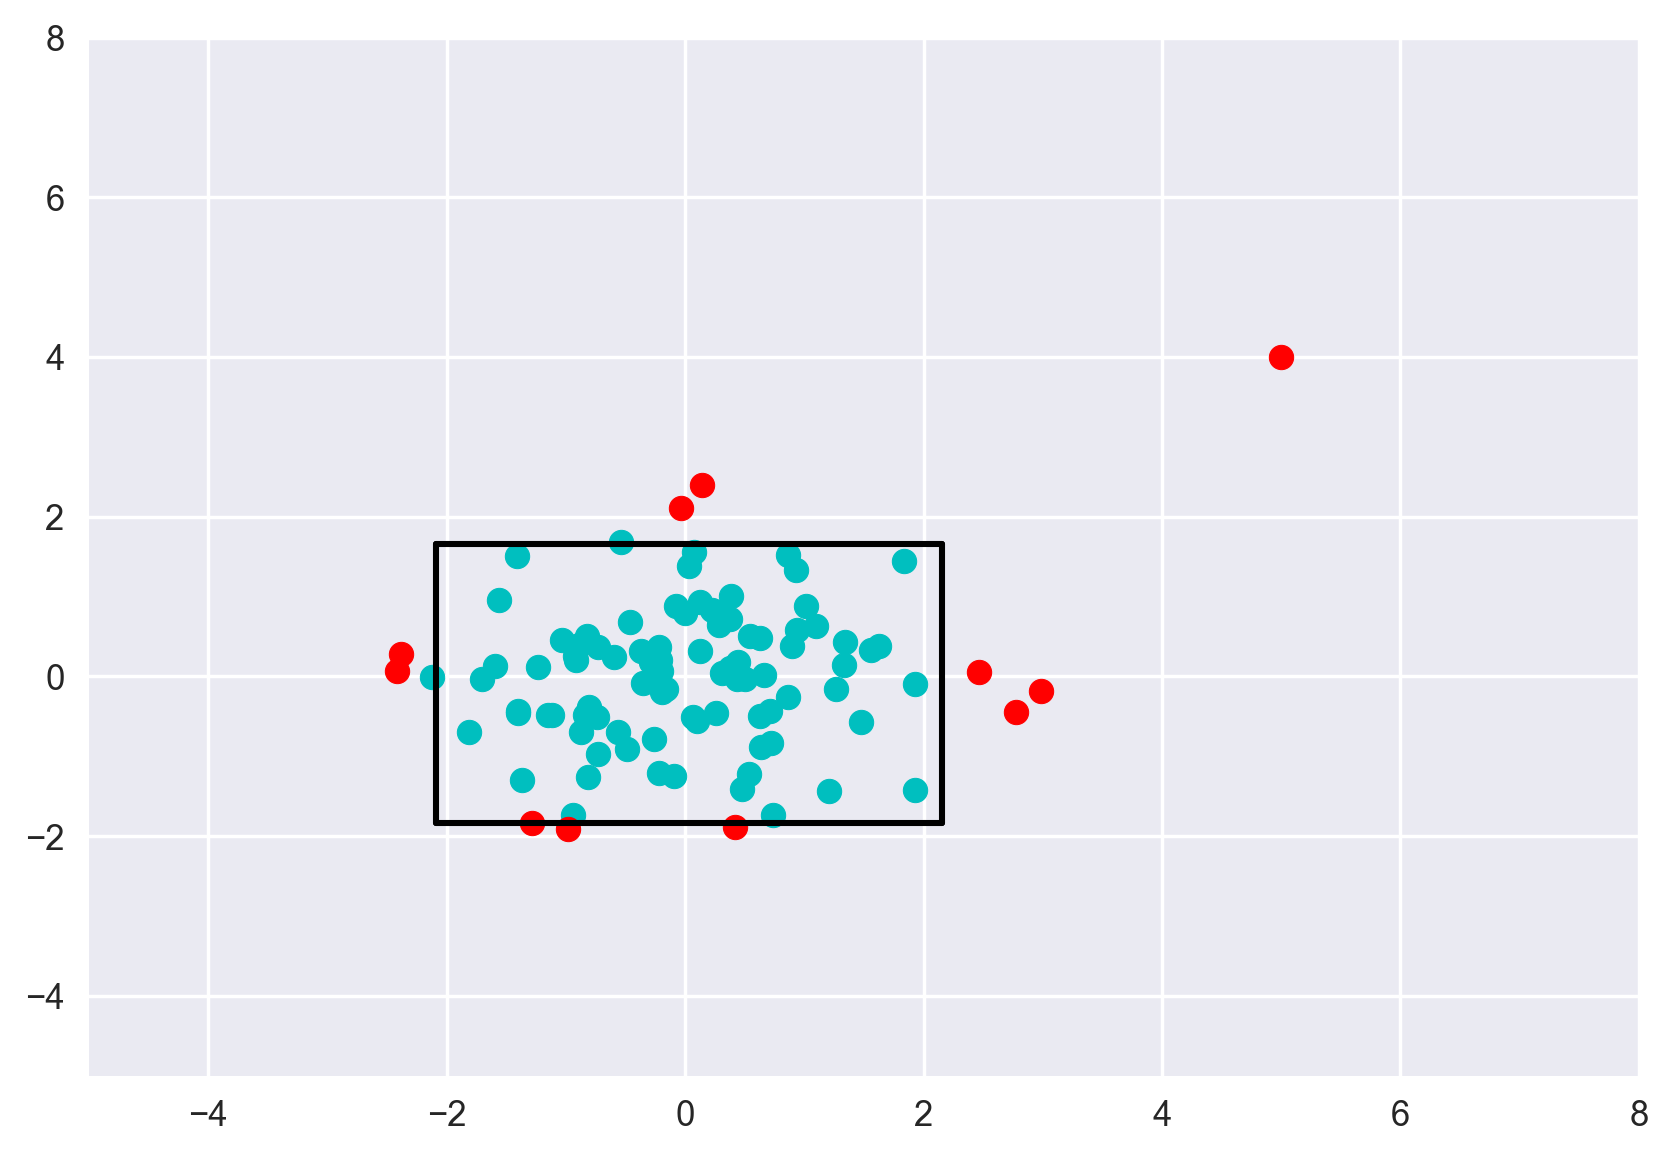

In [12]:
bc = box_covariance(threshold=2)
bc.fit(X)

plt.figure(dpi=250)
for pt,label in zip(X,bc.predict(X)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c')
    else:
        plt.scatter(pt[0], pt[1],c='r') 
        
for pt,label in zip(outlier,bc.predict(outlier)):
    if label > 0:
        plt.scatter(pt[0], pt[1],c='c')
    else:
        plt.scatter(pt[0], pt[1],c='r')  
        
plt.xlim(-5,8)
plt.ylim(-5,8)
xlow = bc.data_stats[0][0] - bc.data_stats[0][1]*bc.threshold
xhigh = bc.data_stats[0][0] + bc.data_stats[0][1]*bc.threshold
ylow = bc.data_stats[1][0] - bc.data_stats[1][1]*bc.threshold
yhigh = bc.data_stats[1][0] + bc.data_stats[1][1]*bc.threshold
plt.plot([xlow,xhigh],[ylow,ylow],'k')
plt.plot([xlow,xhigh],[yhigh,yhigh],'k')
plt.plot([xlow,xlow],[ylow,yhigh],'k')
plt.plot([xhigh,xhigh],[ylow,yhigh],'k');